Prostate plan produced using traditional 4 field conrofmal and also IMRT - compare plans

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyEclipseDVH import eclipse_DVH
from scipy import interpolate

## Load data

In [2]:
Conf = eclipse_DVH('Prostate_data_C-5/DVH_conf.txt')
IMRT = eclipse_DVH('Prostate_data_C-5/DVH_IMRT.txt')

Prostate_data_C-5/DVH_conf.txt loaded 	 patID = Conf	 Prescription [Gy] = 78.000
Prostate_data_C-5/DVH_IMRT.txt loaded 	 patID = IMRT	 Prescription [Gy] = 78.000


In [3]:
IMRT.DVH_df.columns

Index(['Bladder', 'BODY_P1', 'GTV1 (Prostate)', 'L Femoral Head',
       'R Femoral Head_1', 'Rectum', 'Seminal Vesicles', 'skin', 'PTVpsv',
       'Pseudo PTVp', 'Pseu PTVp_2-PTVp', 'PsePTVpsv-PTVp_2', 'PTVp2-PTVp',
       'PTVp2', 'PTVpsv-PTVp2', 'Pseudo Bladder', 'Pseudo Rectum', 'PTVp'],
      dtype='object')

## Setup plotting details

In [14]:
PTV_     = {'Name': 'PTV',     
            'ID': 'PTVp',   
            'color' : 'b', 
            'Constraints': [{'Constraint_Gy':78, 'Sign': '^', 'Value_%': 50}]}


Rectum_  = {'Name': 'Rectum',  
            'ID': 'Rectum', 
            'color' : 'r', 
            'Constraints':[{'Constraint_Gy':30, 'Sign': 'v', 'Value_%': 80},
                           {'Constraint_Gy':40, 'Sign': 'v', 'Value_%': 65},
                           {'Constraint_Gy':50, 'Sign': 'v', 'Value_%': 60},
                           {'Constraint_Gy':60, 'Sign': 'v', 'Value_%': 50},
                           {'Constraint_Gy':65, 'Sign': 'v', 'Value_%': 30},
                           {'Constraint_Gy':70, 'Sign': 'v', 'Value_%': 15},
                           {'Constraint_Gy':75, 'Sign': 'v', 'Value_%': 5},
                           {'Constraint_Gy':78, 'Sign': 'v', 'Value_%': 0}]}


Bladder_ = {'Name': 'Bladder', 
            'ID': 'Bladder',
            'color' : 'g', 
            'Constraints': [{'Constraint_Gy':50, 'Sign': 'v', 'Value_%': 50},
                            {'Constraint_Gy':60, 'Sign': 'v', 'Value_%': 25},
                            {'Constraint_Gy':65, 'Sign': 'v', 'Value_%': 50},
                            {'Constraint_Gy':70, 'Sign': 'v', 'Value_%': 35}]}

structures = [PTV_, Rectum_, Bladder_]

## Compare Conformal and IMRT plans

(0, 90)

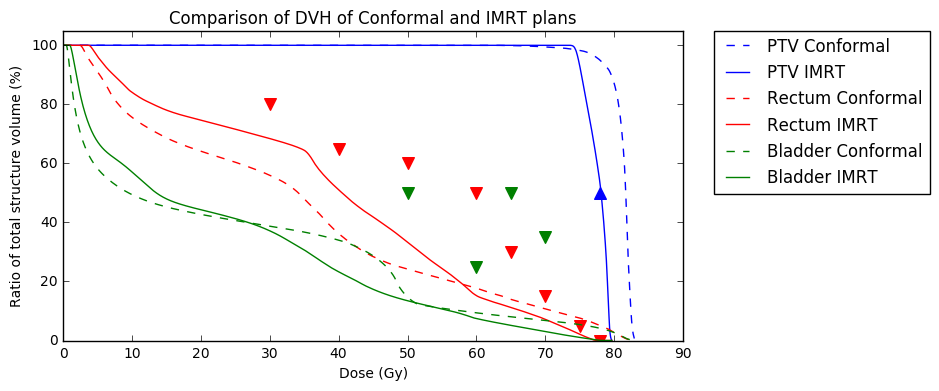

In [15]:
width=8
height=4
plt.figure(figsize=(width, height))

for structure in structures:
    plt.plot(Conf.DVH_df[structure['ID']], label=structure['Name'] + ' Conformal', color = structure['color'], ls='--')
    plt.plot(IMRT.DVH_df[structure['ID']], label=structure['Name'] + ' IMRT', color = structure['color'])

    for constraint in structure['Constraints']:
        plt.scatter(x = constraint['Constraint_Gy'], y = constraint['Value_%'], marker = constraint['Sign'], s=70, color=structure['color'] )  # triangles are ^ or v

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of DVH of Conformal and IMRT plans')
plt.xlabel('Dose (Gy)')
plt.ylabel('Ratio of total structure volume (%)')
plt.ylim([0,105])
plt.xlim([0,90])

In [6]:
Comparison_df = pd.concat([Conf.metrics_df['PTVp'], 
                           IMRT.metrics_df['PTVp'], 
                           Conf.metrics_df['Rectum'], 
                           IMRT.metrics_df['Rectum'], 
                           Conf.metrics_df['Bladder'], 
                           IMRT.metrics_df['Bladder']], 
                           axis=1)
Comparison_df

,PTVp,PTVp,Rectum,Rectum,Bladder,Bladder
Metric,,,,,,
Structure,PTVp,PTVp,Rectum,Rectum,Bladder,Bladder
Approval Status,Approved,Approved,Approved,Approved,Approved,Approved
Plan,Ex2_RC_confm4,Ex2_RC_IMRT,Ex2_RC_confm4,Ex2_RC_IMRT,Ex2_RC_confm4,Ex2_RC_IMRT
Course,RC,RC,RC,RC,RC,RC
Volume [cmÂ³],76.9,76.9,88.8,88.8,442.2,442.2
Dose Cover.[%],100.0,100.0,100.0,100.0,100.0,100.0
Sampling Cover.[%],100.1,100.1,100.0,100.0,100.0,100.0
Min Dose [%],78.8,93.8,3.0,4.7,0.6,1.2
Max Dose [%],106.4,102.2,106.0,99.9,106.3,101.2


## Use interp method to get a dose statistics of type D50% from DVH

Result agree with RadOnc https://dwoll.shinyapps.io/DVHshiny/

In [7]:
def get_Dmetric(df, metric_pct):   # for D50% pass 50
    indexes = np.array(df.index)   # get test data index and values
    values = np.array(df.values)
    f = interpolate.interp1d(values, indexes)  # create the interp object
    return f(metric_pct)

In [8]:
print('The D50% dose is: {} Gy'.format(get_Dmetric(IMRT.DVH_df['PTVp'], 50.0)))

The D50% dose is: 78.08441303800126 Gy


## Calc the homogeneity index

If perfectly homogenous, HI tends to zero, therefore lower values more homogenous

In [9]:
def get_HI(df):   # for D50% pass 50
    indexes = np.array(df.index)   # get test data index and values
    values = np.array(df.values)
    f = interpolate.interp1d(values, indexes)  # create the interp object
    HI = (f(2.0) - f(98.0))/f(50.0)
    return HI 

In [10]:
print('The IMRT HI is: {}'.format(get_HI(IMRT.DVH_df['PTVp'])))

The IMRT HI is: 0.06343513670460232


In [11]:
print('The conf HI is: {}'.format(get_HI(Conf.DVH_df['PTVp'])))

The conf HI is: 0.0886290868450316


# Old

(0, 105)

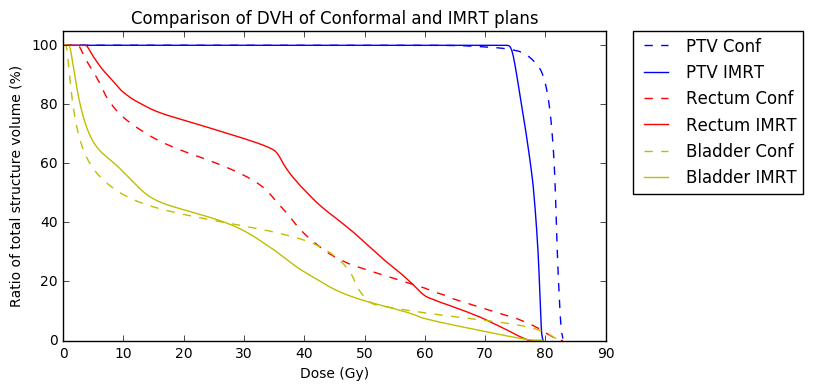

In [12]:
width=7
height=4
plt.figure(figsize=(width, height))

structure = 'PTVp'
plt.plot(Conf.DVH_df[structure], label="PTV Conf", color='b', ls='--')
plt.plot(IMRT.DVH_df[structure], label="PTV IMRT",  color='b' )

structure = 'Rectum'
plt.plot(Conf.DVH_df[structure], label="Rectum Conf", color='r', ls='--')
plt.plot(IMRT.DVH_df[structure], label="Rectum IMRT",  color='r' )

structure = 'Bladder'
plt.plot(Conf.DVH_df[structure], label="Bladder Conf", color='y', ls='--')
plt.plot(IMRT.DVH_df[structure], label="Bladder IMRT",  color='y' )

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of DVH of Conformal and IMRT plans')
plt.xlabel('Dose (Gy)')
plt.ylabel('Ratio of total structure volume (%)')
plt.ylim([0,105])